In [1]:
import os

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as patches

from tifffile import imread

from skimage.util import img_as_float
from skimage.color import gray2rgb

In [2]:
def fmt(x, pos):
    a, b = '{:.1e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

In [3]:
core = '95'  # dedifferentiated liposarcoma
channels = [f'DNA1:{core}']

In [4]:
# read unfiltered single-cell data
data = pd.read_parquet('../datasets/Dataset3(TMA)/TMA_cylinter_cleaned_aggregateData.parquet')

In [5]:
# out dir
out_dir = '../output/Fig1i'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

In [6]:
# read DNA1, pCREB, and segmentation outlines of selected core and crop to target size
dna = imread(f'../datasets/Dataset3(TMA)/tif/{core}.ome.tif', key=0)
pcreb = imread(f'../datasets/Dataset3(TMA)/tif/{core}.ome.tif', key=33)
seg = imread(f'../datasets/Dataset3(TMA)/seg/{core}.ome.tif', key=0)

ymin_crop = 0
ymax_crop = dna.shape[1]
xmin_crop = 0
xmax_crop = dna.shape[0]
dna_crop = dna[ymin_crop:ymax_crop, xmin_crop:xmax_crop]
pcreb_crop = pcreb[ymin_crop:ymax_crop, xmin_crop:xmax_crop]
seg_crop = seg[ymin_crop:ymax_crop, xmin_crop:xmax_crop]

ymin_zoom = 1925
ymax_zoom = 2205
xmin_zoom = 2015
xmax_zoom = 2295
dna_zoom = dna[ymin_zoom:ymax_zoom, xmin_zoom:xmax_zoom]
pcreb_zoom = pcreb[ymin_zoom:ymax_zoom, xmin_zoom:xmax_zoom]
seg_zoom = seg[ymin_zoom:ymax_zoom, xmin_zoom:xmax_zoom]

# rescale seg_zoom to float(0-1) and convert to RGB
seg_zoom = img_as_float(seg_zoom)
seg_zoom -= seg_zoom.min()
seg_zoom /= seg_zoom.max()
seg_zoom = gray2rgb(seg_zoom)
seg_zoom = seg_zoom * (0.6, 0.6, 0.6)

# rescale pcreb_zoom to float(0-1) and convert to RGB
pcreb_zoom = img_as_float(pcreb_zoom)
pcreb_zoom -= pcreb_zoom.min()
pcreb_zoom /= pcreb_zoom.max()
pcreb_zoom = plt.cm.magma(pcreb_zoom) # converts to RGBA automatically
pcreb_zoom = pcreb_zoom[:, :, 0:3]  # drop alpha dimension
pcreb_zoom = pcreb_zoom/1.3  # dim pCREB


In [7]:
# select cells within cropped image
data_zoom = data[['Y_centroid', 'X_centroid', 'pCREB']][
    (data['Sample'] == core) &
    (data['X_centroid'].between(xmin_zoom, xmax_zoom, inclusive='both')) &
    (data['Y_centroid'].between(ymin_zoom, ymax_zoom, inclusive='both'))
    ]

# transform x, y coordinates of cells within cropped image
data_zoom['X_centroid'] = data_zoom['X_centroid']-xmin_zoom
data_zoom['Y_centroid'] = data_zoom['Y_centroid']-ymin_zoom

# select cells within rectangular ROI
data_rec_zoom = data_zoom[
    (data_zoom['X_centroid'].between(15, 270, inclusive='neither')) &
    (data_zoom['Y_centroid'].between(100, 150, inclusive='neither'))
    ]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


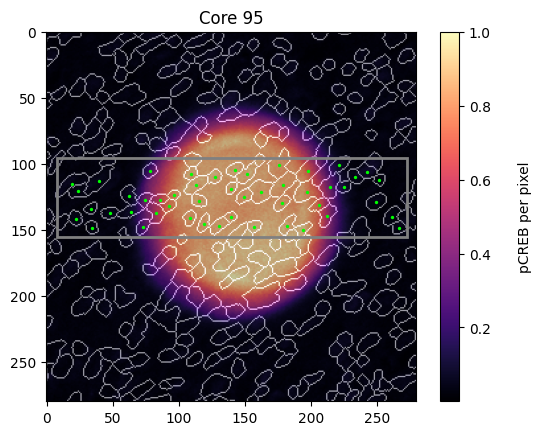

In [8]:
# plot cropped image
seg_zoom += pcreb_zoom

plt.imshow(seg_zoom, cmap='magma')

plt.grid(False)

plt.savefig(os.path.join(out_dir, 'optical_artifact_img_raster.png'), dpi=600)

rect = patches.Rectangle((8, 95), 265, 60, linewidth=2, edgecolor='gray', facecolor='none')
plt.gca().add_patch(rect)
cbar = plt.colorbar()
cbar.set_alpha(1.0)
cbar.set_label('pCREB per pixel', labelpad=20, rotation=90)
plt.title(f'Core {core}')
plt.scatter(data_rec_zoom['X_centroid'], data_rec_zoom['Y_centroid'], s=2.0, color='lime')
plt.savefig(os.path.join(out_dir, 'optical_artifact_img_vector.pdf'))
plt.show()
plt.close('all')

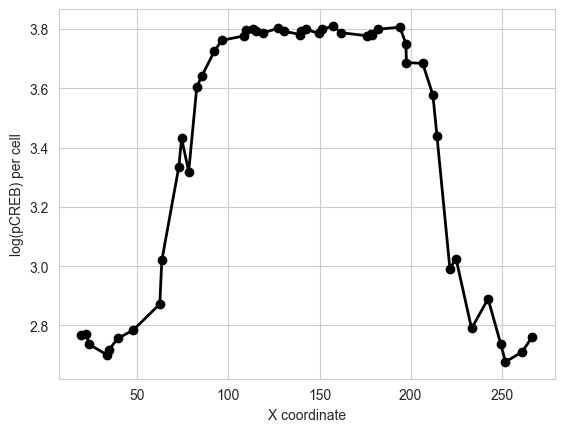

In [9]:
# sort cells within rectangular ROI according to their X centroid
# then plot X centroids of cells against their log-transformed mean pCREB signal
data_rec_zoom = data_rec_zoom.sort_values(by='X_centroid')
data_rec_zoom.set_index('X_centroid', drop=False, inplace=True)
sns.set_style('whitegrid')
plt.plot(np.log10(data_rec_zoom['pCREB']), marker='o', lw=2.0, c='k')
plt.xlabel('X coordinate')
plt.ylabel('log(pCREB) per cell')
plt.savefig(os.path.join(out_dir, 'optical_artifact_trace.pdf'))
plt.show()
plt.close('all')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


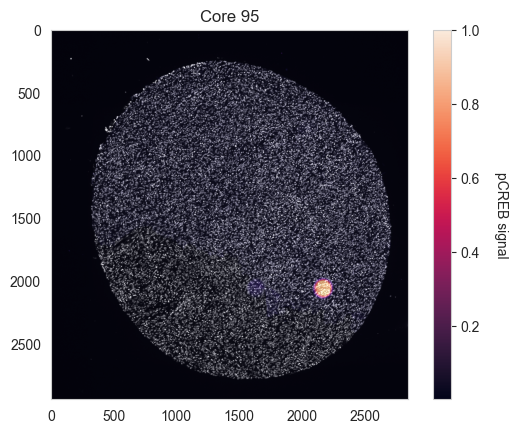

In [10]:
# rescale dna_crop to float(0-1) and convert to RGB
dna_crop = img_as_float(dna_crop)
dna_crop -= dna_crop.min()
dna_crop /= dna_crop.max()
dna_crop = gray2rgb(dna_crop)

# remove bright spot at far right of image so colomaps correspond between low and high mag images
pcreb_crop = pcreb_crop[:, 0:-100]
dna_crop = dna_crop[:, 0:-100]

# rescale pcreb_crop to float(0-1) and convert to RGB
pcreb_crop = img_as_float(pcreb_crop)
pcreb_crop -= pcreb_crop.min()
pcreb_crop /= pcreb_crop.max()
pcreb_crop = plt.cm.magma(pcreb_crop)  # converts to RGBA automatically
pcreb_crop = pcreb_crop[:, :, 0:3]  # drop alpha dimension

dna_crop = dna_crop*4  # brighten DNA
pcreb_crop = pcreb_crop/1.3  # dim pCREB
dna_crop += pcreb_crop  # combine images 

plt.imshow(dna_crop)

rect = patches.Rectangle((2020, 1925), 280, 280, linewidth=1, edgecolor=[0.6, 0.6, 0.6, 1.0], facecolor='none')
# plt.gca().add_patch(rect)
plt.grid(False)
cbar = plt.colorbar()
cbar.set_alpha(1.0)
cbar.set_label('pCREB signal', labelpad=20, rotation=270)
# plt.colorbar(format=ticker.FuncFormatter(fmt))
plt.title(f'Core {core}')
plt.savefig(os.path.join(out_dir, 'optical_artifact_img_crop.png'), dpi=600)
plt.savefig(os.path.join(out_dir, 'optical_artifact_img_crop.pdf'))
plt.show()
plt.close('all')